# Quickstart

This guide aims to help new users get started with VAPOR's Python API, showcasing a typical workflow using an example dataset. We will cover some of the key features of the VAPOR API, and explain some of the essential concepts specific to 3D visualization in VAPOR.

Creating visualization in VAPOR can be divided into 4 steps, which we will go through in this notebook. 
1. **Import Data**

2. **Select and Apply Renderers**

3. **Annotate**

4. **Export**

## Setup

### Import VAPOR

To begin, we will import the vapor modules we will be using.

In [211]:
from vapor import session, renderer, dataset
from vapor.animation import Animation
from vapor.dataset import Dataset

### Initialize Session

3D visualizations in VAPOR are managed using [sessions](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.session.html). A session captures all the necessary information to recreate a visualization, including dataset details, rendering settings, and camera positions. In this notebook, we'll create a new visualization within a session. Later, we can save this session to a file, allowing it to be opened in VAPOR's GUI application or another Python script.

In [212]:
ses = session.Session()

### Load Data

Once we've created our session, we'll want to load our dataset. Vapor supports a number of scientific data formats, which can be viewed with `Dataset.GetDatasetTypes()`

In [213]:
Dataset.GetDatasetTypes()

['vdc', 'wrf', 'cf', 'mpas', 'bov', 'ugrid']

In this example, we will be using data from the WRF model of Hurricane Katrina from 2005. The following cell will download the data from NCAR's [Research Data Archives](https://rda.ucar.edu/datasets/ds897.7/dataaccess/#).

In [214]:
import os
import requests
import zipfile
url = 'https://data.rda.ucar.edu/ds897.7/Katrina.zip'
extract_to = './data'
zip_name = "Katrina.zip"
data_file = './data/wrfout_d02_2005-08-29_02.nc'

# Check if the data file already exists
if not os.path.exists(data_file):
    # Download zip
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_name, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    # Extract the file
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Clean up the zip file
    os.remove(zip_name)

    print(f"Data downloaded and extracted to {data_file}")
else:
    print(f"Data file already exists at {data_file}, skipping download and extraction.")


Data file already exists at ./data/wrfout_d02_2005-08-29_02.nc, skipping download and extraction.


To load the dataset into our session, we use `ses.OpenDataset()`, which requires two parameters. The first parameter specifies the file format, in this case, dataset.WRF. The second parameter is a list of file paths. Since we only have one file, we provide a list containing just that file.

In [215]:
data = ses.OpenDataset(dataset.WRF, ["data/wrfout_d02_2005-08-29_02.nc"])

The dataset contains a number of atmospheric variables that describe attributes of the storm, such as pressure, wind, clouds, and rain. For this example, we will use three variables: `U10`, a 2 dimensional variable that describes the 10 meter zonal wind speed, `QCLOUD`, a 3 dimensional variable to visualize the cloud formation of the storm, and `HGT`, a 2D variable to visualize the topography of the land. Below we will display the metadata for these variables.

In [216]:
print("Data Variables:")
vars = ["U10", "QCLOUD", "HGT"]
for var in data.GetDataVarNames():
    if var in vars:
        print(f" {var}")
        print(f"    Time Varying: False")
        print(f"    Dimensionality:", data.GetVarGeometryDim(var))
        print(f"    Coordinates:", data.GetVarCoordVars(var, True))
        print("     Data Range:", data.GetDataRange(var))

Data Variables:
 HGT
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [-4.76837158203125e-07, 435.46844482421875]
 U10
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [-57.80490493774414, 66.07730865478516]
 QCLOUD
    Time Varying: False
    Dimensionality: 3
    Coordinates: ['XLONGX', 'XLATY', 'Elevation']
     Data Range: [-8.626847608668442e-13, 0.002441433956846595]


## Apply Renderers

Now that we've loaded our data, it's time to start the visualization process. Visualization in Vapor is based around renderers, which display data with customizable colors and opacities. Tutorials for using renderers in Vapor's GUI can be found [here](https://ncar.github.io/VaporDocumentationWebsite/vaporApplicationReference/renderers.html), and each one works similarly in Python. In this example, we'll create a 2D data renderer and a volume renderer.

### Image Renderer

We will start by creating an image renderer to display the topography of the land. This dataset is georeferenced, so we can use Vapor's builtin image simply by calling `data.NewRenderer(renderer.ImageRenderer)`. Additionally, our dataset stores the elevation at each gridpoint in `HGT`, and by linking this to our image renderer with `land.SetHeightVariableName("HGT")` we can render the topography in 3D.

In [218]:
land = data.NewRenderer(renderer.ImageRenderer)
land.SetHeightVariableName("HGT")

Now, we can call `ses.Show()` to display our visualization!

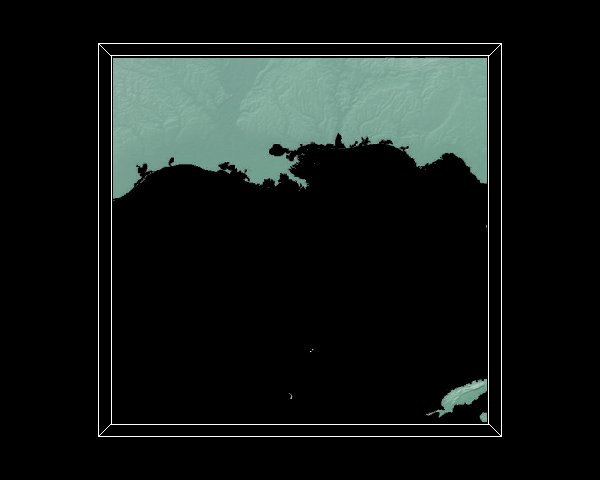

In [219]:
ses.Show()

### 2D Data Renderer

The 2D Data Renderer displays a 2D data variable along the plane described by the dataset. We will use it to display our U10 variable, which represents the east/west wind speed at a 10-meter elevation. First, we select the renderer type by calling `NewRenderer()` on the dataset. Next, we specify the variable to visualize by calling `SetVariableName()` on the renderer.

In [196]:
wind = data.NewRenderer(renderer.TwoDDataRenderer)
wind.SetVariableName("U10")

If our image and 2D data renderers are too close to each other, it can lead to unexpected results. To prevent this, we'll lift our image renderer slightly off the ground. We can achieve this by using `GetTransform()` and `SetTranslations()` as follows.

In [197]:
land_transform = land.GetTransform()
land_transform.SetTranslations([0, 0, 100])

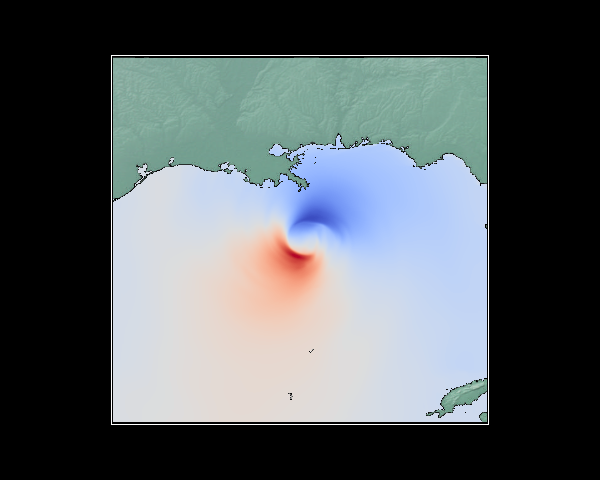

In [198]:
ses.Show()

### Volume Renderer

Next, let's create a visualization for a three dimensional variable. The `QCLOUD` variable measures the cloud density at every gridpoint. We can use a volume renderer to display where the clouds are thickest. As before, we first select our renderer and variable name.

In [200]:
clouds = data.NewRenderer(renderer.VolumeRenderer)
clouds.SetVariableName("QCLOUD")

We can adjust the appearance of our renderer by modifying its [transfer function](https://ncar.github.io/VaporDocumentationWebsite/vaporApplicationReference/basicRendererControls.html#appearancetab), which describes the color and opacity of the data in the visualization. The [transfer function notebook](https://projectpythia.org/vapor-python-cookbook/notebooks/transfer_function_example.html) provides more examples on how to customize a transfer function.

First, we will set the colors to a white-gray-black scale. Then, we will adjust the opacities of the renderer. We want areas with almost no clouds to be completely transparent, while areas with more clouds should be more opaque. We use `SetOpacityControlPoints` with a list of [value, opacity] pairs to specify the opacity of data points with a certain value.

In [201]:
clouds_tf = clouds.GetTransferFunction("QCLOUD")
# Load built in black to white colormap
clouds_tf.LoadBuiltinColormap("Sequential/BlackWhite")
# Access and reverse RGB list from current color map
new_colors = [(r, g, b) for r, g, b, _ in list(reversed(clouds_tf.GetMatPlotLibColormap().colors))]
# Assign new RGB colors to transfer function
clouds_tf.SetColorRGBList(new_colors)
# Change opacities
clouds_tf.SetOpacityControlPoints([[0,0],[0.00001,0.01], [0.0001, 0.1], [0.0010,0.9]])

To visualize the 3D structure of the clouds effectively, we need to set the camera at an appropriate angle. The [camera module](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.camera.html) in VAPOR offers several functions for controlling the camera's position and orientation. Among these, the `LookAt()` function is the most robust and versatile. It takes two lists, each containing three elements representing a point in 3D space with (X, Y, Z) coordinates. The first list specifies the camera's position, while the second list defines the point the camera is targeting.

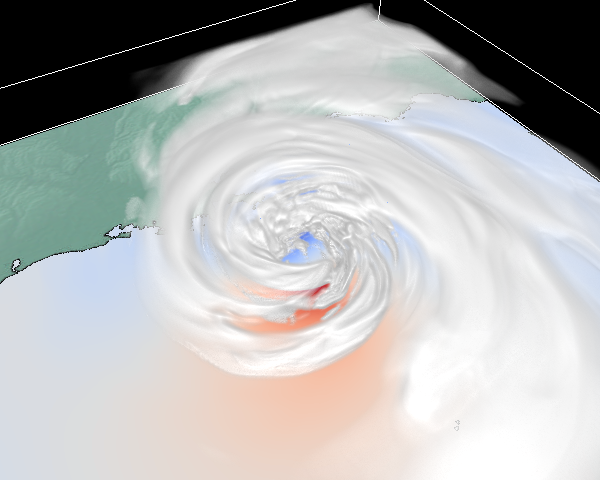

In [202]:
ses.GetCamera().LookAt(
    [-757400, 2189800, 761600], # Position
    [-420800, 2737200, 15700]   # Target
    )
ses.Show()

## Add Annotations

We can finalize our visualization with some [annotations](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.annotations.html). For a more in depth tutorial on annotations, visit our [annotation cookbook](https://projectpythia.org/vapor-python-cookbook/notebooks/annotation_example.html). Here, we'll add a colorbar for our wind variable and axis arrows to help with orientation.

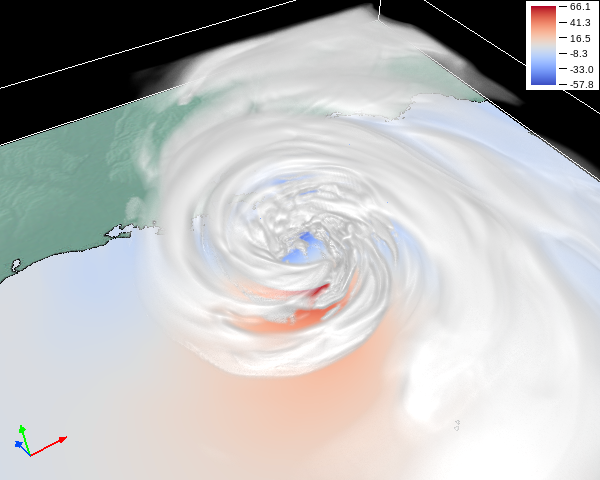

In [203]:
colorbar = wind.GetColorbarAnnotation()
colorbar.SetEnabled(True)
colorbar.SetCornerPosition((1,1))

scene = ses.GetSceneAnnotations()
scene.SetAxisArrowEnabled(True)

ses.Show()

We can also generate an interactive visual using Vapor's jupyter widget. This allows you to move the camera around as if you were using the Vapor application.  
*Note: This widget requires an active kernel to operate. To try it out, run this notebook on your local machine.*

In [204]:
from jupyter_vapor_widget import *
viz = VaporVisualizerWidget(ses)
viz

VaporVisualizerWidget(imageData='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH…

## Export

Now that we've created our visualization, we'll want to save and export it. We can save visualization as a png, jpg, or tif using `ses.Render()`

In [205]:
ses.Render("Katrina.tif")

0

We can also use `ses.Save()` to save our session to a file. We can load this file in a different python script or in the Vapor GUI.

In [206]:
ses.Save("Katrina.vs3")

0

To access this session in a different Python script, we can use a line like this:

In [207]:
ses = session.Session()
ses.Load("Katrina.vs3")

Dataset: 'wrfout_d02_2005-08-29_02.nc'


0